# New section

In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from tensorflow.keras.utils import plot_model
print(tf.__version__)

2.17.1


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

batch_size = 32
img_height = 224
img_width = 224
lr_rate = 1e-3
lr_mode = 'cos'
epochs = 30
data_dir = pathlib.Path('/content/drive/MyDrive/Train').with_suffix('')

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 7538 files belonging to 6 classes.
Using 6031 files for training.
Found 7538 files belonging to 6 classes.
Using 1507 files for validation.
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


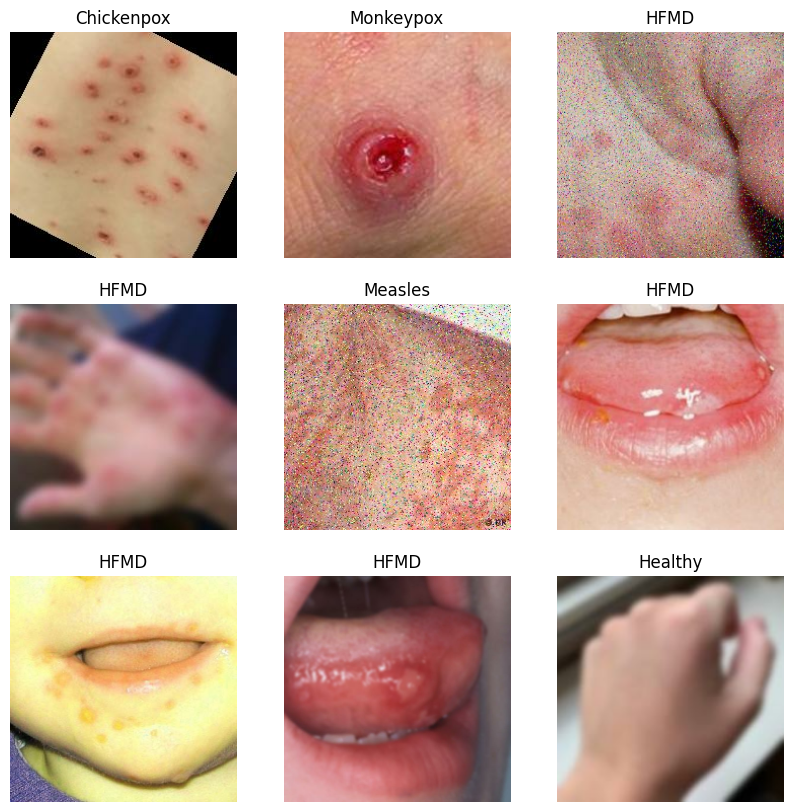

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.27738172 0.87003684


In [11]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
base_model.trainable = False

In [13]:
inputs = keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(6)(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 512)           │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,432,046 (116.09 MB)

 Trainable params: 9,570,566 (36.51 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

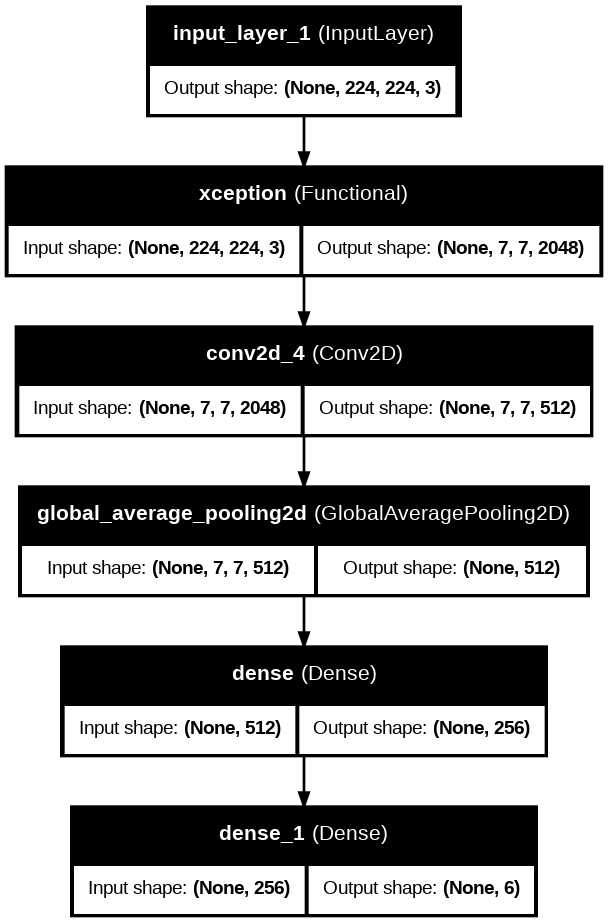

In [14]:
plot_model(
    model,
    to_file="resnet_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    dpi=96
)

In [15]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

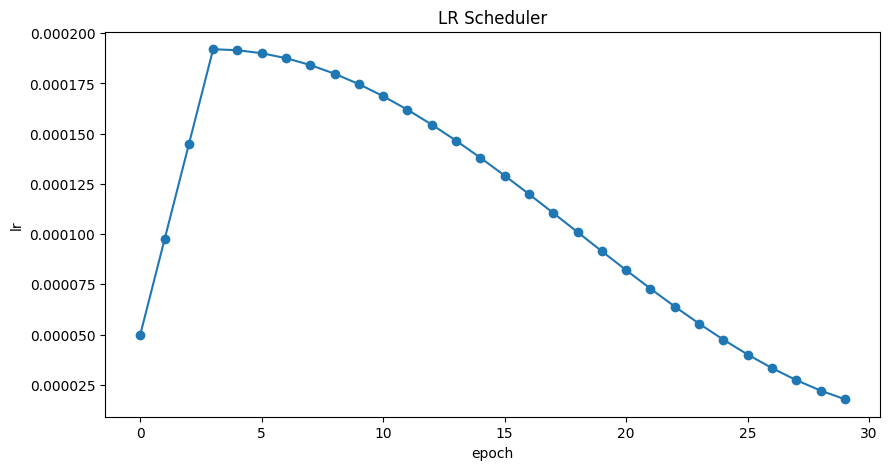

In [16]:
lr_cb = get_lr_callback(batch_size, mode=lr_mode, plot=True, epochs=epochs)

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=train_ds)

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 2117s 11s/step - accuracy: 0.3652 - loss: 6.3736 - val_accuracy: 0.5414 - val_loss: 1.5503 - learning_rate: 5.0000e-05
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 59s 266ms/step - accuracy: 0.5044 - loss: 2.1011 - val_accuracy: 0.6365 - val_loss: 1.0633 - learning_rate: 9.7333e-05
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - accuracy: 0.6045 - loss: 1.3262 - val_accuracy: 0.6503 - val_loss: 1.0372 - learning_rate: 1.4467e-04
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 98s 364ms/step - accuracy: 0.6555 - loss: 1.0673 - val_accuracy: 0.7261 - val_loss: 0.8319 - learning_rate: 1.9200e-04
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.6990 - loss: 0.8706 - val_accuracy: 0.6939 - val_loss: 0.8638 - learning_rate: 1.9150e-04
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 81s 280ms/step - accuracy: 0.7329 - loss: 0.8028 - val_accuracy: 0.6850 - val_loss: 0.9192 - learning_rate: 1.9001e-04
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 55s 28

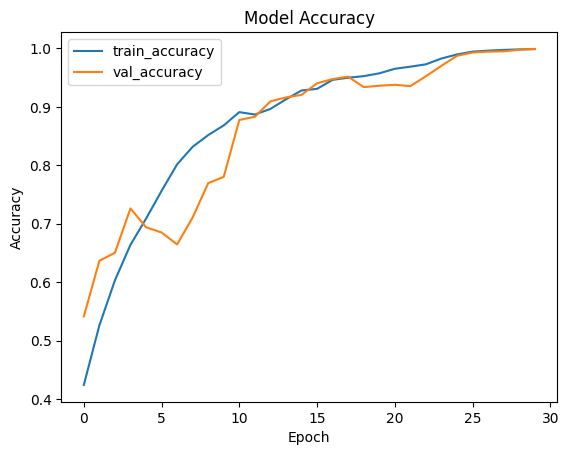

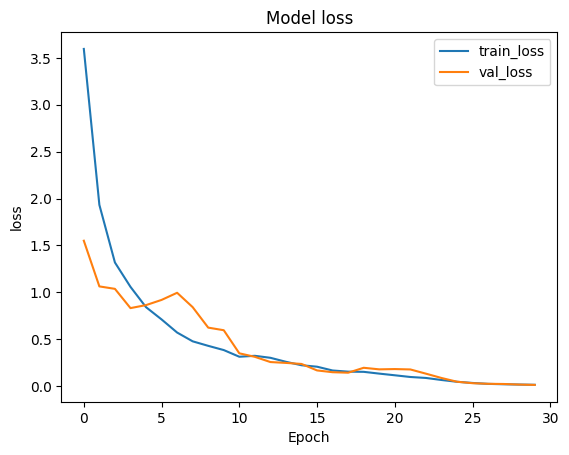

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [21]:
test_data_dir = '/content/drive/MyDrive/FOLDS/fold1/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 144 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 67s 13s/step - accuracy: 0.5174 - loss: 3.5304


[3.677140951156616, 0.5208333134651184]

In [23]:
test_data_dir = '/content/drive/MyDrive/FOLDS/fold1/Test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 74 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 11s/step - accuracy: 0.4904 - loss: 3.0456


[3.1694798469543457, 0.47297295928001404]

In [24]:
test_data_dir = '/content/drive/MyDrive/FOLDS/fold2/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 164 files belonging to 6 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.9044 - loss: 0.5722


[0.4245513379573822, 0.9329268336296082]

In [25]:
test_data_dir = '/content/drive/MyDrive/FOLDS/fold3/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 153 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 14s/step - accuracy: 0.8266 - loss: 1.2137


[1.0693861246109009, 0.8562091588973999]

In [26]:
test_data_dir = '/content/drive/MyDrive/FOLDS/fold4/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


model.evaluate(test_ds)

Found 150 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 13s/step - accuracy: 0.8313 - loss: 2.2599


[1.605181097984314, 0.846666693687439]

In [27]:
test_data_dir = '/content/drive/MyDrive/FOLDS/fold5/Valid'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 154 files belonging to 6 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 67s 14s/step - accuracy: 0.8361 - loss: 1.2165


[1.1822736263275146, 0.8571428656578064]

In [28]:
model.save('Xception_CNN_V2_fineTunedd.keras')
!mkdir checkpoints
model.save_weights('checkpoints/Xception_CNN_V2_fineTunedd.weights.h5')
#Export the model for inference
model.export('export/exported_Xception_CNN_V2_fineTunedd_model')

Saved artifact at 'export/exported_Xception_CNN_V2_fineTunedd_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137514586342496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514116817568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514116816512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514632601040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514116813872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514116812288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514117176960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514117178016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514117172912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137514117176784: TensorSpec(shape=(), dtype=tf.r

In [32]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
predictions =model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 617ms/step


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras

In [33]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.64      0.47      0.54        15
      Cowpox       0.83      0.94      0.88        16
        HFMD       0.94      0.84      0.89        37
     Healthy       0.86      0.86      0.86        21
     Measles       0.85      1.00      0.92        11
   Monkeypox       0.86      0.93      0.89        54

    accuracy                           0.86       154
   macro avg       0.83      0.84      0.83       154
weighted avg       0.85      0.86      0.85       154



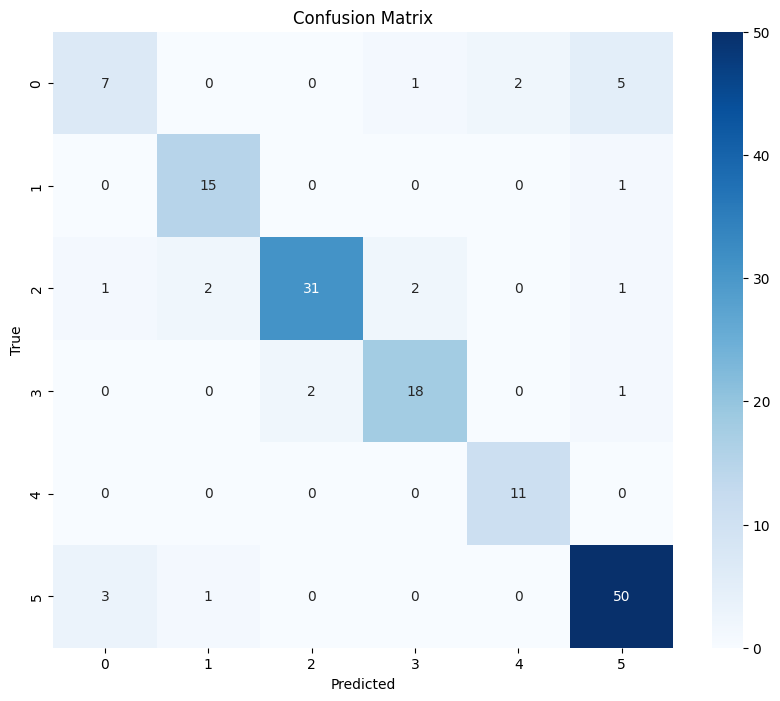

In [35]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()